In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import utils 

from torch.utils.data import DataLoader
from torchvision import transforms

from unet import UNet
from utils import generate_random_data
from data import GDataset
%matplotlib inline

### Dice coefficient for model evaluation is used: 
${Dice(A,B) = \frac{2|AB|}{|A| + |B|}}$

In [85]:
def dice(pred, target):
    intersection = (pred*target).sum(axis=2).sum(axis=2)
    
    d = (2.*intersection) / (pred.sum(axis=2).sum(axis=2) + target.sum(axis=2).sum(axis=2))
    
    return d.mean()

### Preparing model and data for evaluation

In [86]:
num_of_classes = 6

#Using GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Loading pretrained model
model = UNet(num_of_classes)
model.load_state_dict(torch.load('unet_model.pt'))
model.eval()
model = model.to(device)

trans = transforms.Compose([
    transforms.ToTensor(),
])

#Generating test data
test_dataset = GDataset(3000, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=0)

### Computating dice coefficient throught all test data

In [87]:
dice_coef = 0
iterations = 0
for inputs, labels in test_loader:
    if iterations % 20 == 0:
        print("Iteration's number: {}".format(iterations))
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    pred = model(inputs)

    pred = pred.data.cpu().numpy()
    pred = np.clip(pred, 0, 1)
    labels = labels.data.cpu().numpy()
    dice_coef += dice(np.where(pred > 0.5, 1, 0), labels)
    iterations += 1

dice_coef /= iterations

Iteration's number: 0
Iteration's number: 20
Iteration's number: 40
Iteration's number: 60
Iteration's number: 80
Iteration's number: 100
Iteration's number: 120
Iteration's number: 140
Iteration's number: 160
Iteration's number: 180
Iteration's number: 200
Iteration's number: 220
Iteration's number: 240
Iteration's number: 260
Iteration's number: 280


### Result

In [88]:
dice_coef

0.9687051651361075

### For image segmantation Jaccard similarity index is also used:
${Jacc(A, B) = \frac{|AB|}{|A \cup B|}}$


It may be calculated as follow:
${J = \frac{D}{2 - D}}$

Jaccard is always less than or equal min(Precision,Recall); Dice is always in-between.

In [89]:
jaccard = dice_coef / (2 - dice_coef)
print(jaccard)

0.9393096255194127


### Visualization of last batch predictions

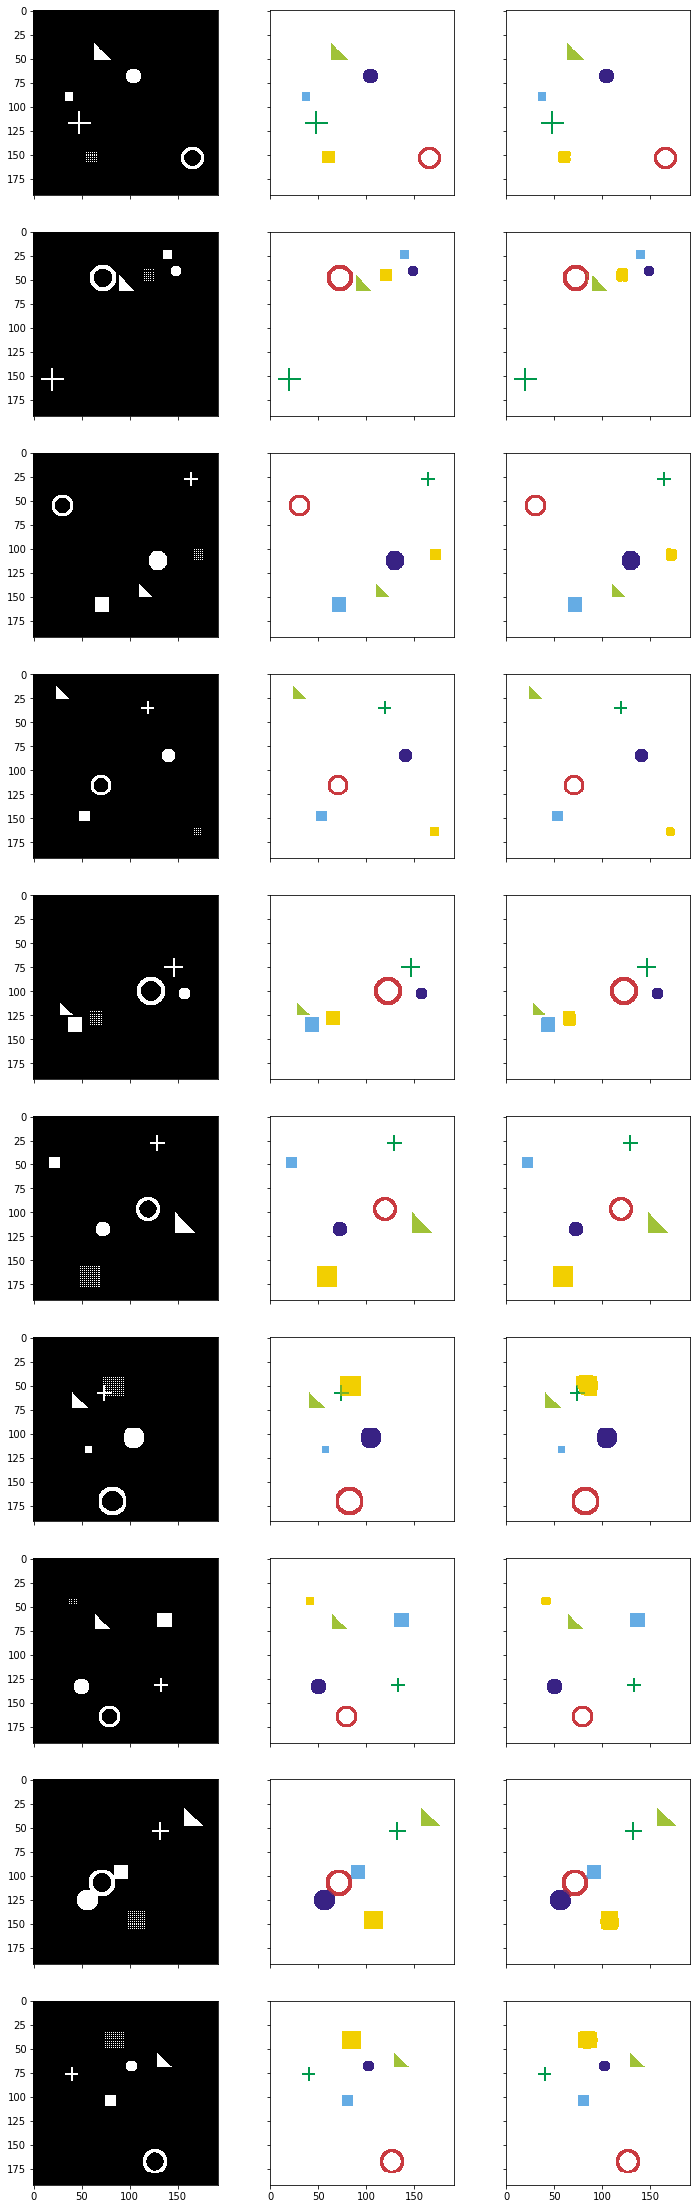

In [90]:
input_images_rgb = [(x.transpose((1,2,0)) * 255).astype(np.uint8) for x in inputs.data.cpu().numpy()]
target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels]
pred_rgb = [utils.masks_to_colorimg(x) for x in np.where(pred > 0.5, 1, 0)]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])